In [49]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np

import pandas as pd

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


In [50]:
data_dir = r'C:\Users\Oggy\Documents\Autonomous_Car\data'


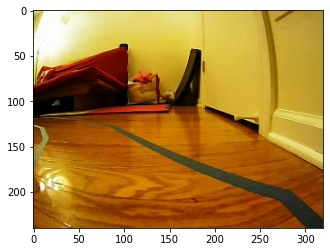

In [51]:
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4]) 
        steering_angles.append(angle)
len(steering_angles)
#steering_angles


image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
#print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))


In [53]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

In [54]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [55]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

In [56]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

In [57]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

In [58]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle


In [59]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]               # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66))             # input image size (200,66)
    image = image / 255                             # normalizing, the processed image
    return image

In [45]:
def Z_model():
    model = Sequential(name='Atonomous_ML_lab')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())   #converts in 1D vector
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # we use MSE (Mean Squared Error) as loss function coz  regression problem 
    optimizer = Adam(learning_rate=1e-3) # lr is learning rate  ->optimization technique for gradient descent
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [43]:
model = Z_model()
#print(model.summary())
# check at we will have 252,219 trainable parameters

In [47]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [48]:
X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, 2, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, 2, False))

In [18]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join('Z_LKAS_chk.h5'), verbose=1, save_best_only=True)


history = model.fit(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join('Z_LKAS_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 641.7966
Epoch 1: val_loss improved from inf to 533.42035, saving model to Z_LKAS_chk.h5
300/300 [==============================] - 264s 881ms/step - loss: 641.7966 - val_loss: 533.4203
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 399.9461
Epoch 2: val_loss improved from 533.42035 to 91.28658, saving model to Z_LKAS_chk.h5
300/300 [==============================] - 271s 905ms/step - loss: 399.9461 - val_loss: 91.2866
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 80.2054
Epoch 3: val_loss improved from 91.28658 to 23.06561, saving model to Z_LKAS_chk.h5
300/300 [==============================] - 270s 903ms/step - loss: 80.2054 - val_loss: 23.0656
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 32.3453
Epoch 4: val_loss improved from 23.06561 to 14.75686, saving model to Z_LKAS_chk.h5
300/300 [==============================] - 271s 906ms/step - loss

In [60]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model('Z_LKAS_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

In [61]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

mse       = 5.0
r_squared = 92.59%



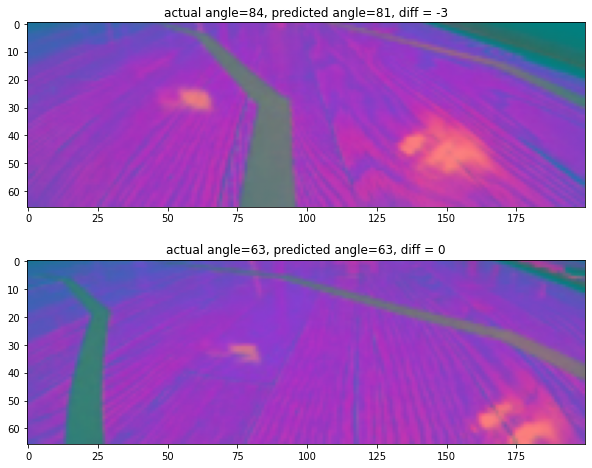

In [41]:
n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
  